# Earthquake Prediction

#### Table of Contents
0. Setup
1. Data Analysis
2. Data Preparation
3. Model Training
4. Model Evaluation

In [263]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import preprocessing, model_selection, linear_model
from sklearn.metrics import accuracy_score, mean_absolute_error

## 0. Setup

In [264]:
filepath = './data/earthquakes_last_30_days.csv'

## 1. Data Analysis

In [265]:
df = pd.read_csv(filepath)
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-08-18T11:29:57.850Z,18.987499,-155.431671,33.680,2.76,ml,47.0,225.0,NaN,0.13,...,2022-08-18T12:23:58.514Z,"17 km ESE of Naalehu, Hawaii",earthquake,0.55,0.930,0.630,4.0,automatic,hv,hv
1,2022-08-18T09:39:19.617Z,27.554600,139.788700,496.853,4.80,mb,122.0,45.0,5.542,0.62,...,2022-08-18T10:04:50.040Z,"Bonin Islands, Japan region",earthquake,10.78,6.395,0.026,455.0,reviewed,us,us
2,2022-08-18T09:28:29.331Z,23.962600,122.409900,24.596,4.40,mb,28.0,116.0,0.744,0.51,...,2022-08-18T10:21:12.040Z,"81 km SW of Yonakuni, Japan",earthquake,4.92,6.785,0.155,12.0,reviewed,us,us
3,2022-08-18T07:46:27.540Z,0.340300,124.375200,166.522,5.40,mww,83.0,47.0,2.111,1.00,...,2022-08-18T09:50:10.951Z,"118 km SSW of Tomohon, Indonesia",earthquake,6.32,4.939,0.071,19.0,reviewed,us,us
4,2022-08-18T07:21:54.330Z,18.422600,-64.788600,97.000,3.78,md,16.0,350.0,0.182,0.03,...,2022-08-18T07:48:53.040Z,"10 km N of Cruz Bay, U.S. Virgin Islands",earthquake,5.57,1.010,0.110,9.0,reviewed,pr,pr


In [266]:
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,1459.000000,1459.000000,1459.000000,1459.000000,1393.000000,1393.000000,1175.000000,1459.000000,1379.000000,1459.000000,1383.000000,1387.000000
mean,17.572005,-20.248707,58.922615,3.913139,43.832735,126.474013,2.801494,0.531346,6.025692,3.784608,0.126259,42.302091
std,27.612054,119.875649,109.735295,0.893684,36.689596,68.914287,3.801281,0.298711,4.280060,4.517890,0.166470,64.821202
min,-62.742200,-179.987200,-3.630000,2.500000,3.000000,16.000000,0.000000,0.030000,0.090000,0.000000,0.000000,0.000000
25%,-1.014950,-117.478250,10.000000,3.000000,20.000000,71.000000,0.450500,0.270000,1.413743,1.333000,0.071000,11.000000
50%,18.969667,-66.879667,13.310000,4.200000,32.000000,114.000000,1.711000,0.540000,6.260000,1.907000,0.104000,20.000000
75%,36.573583,121.989150,53.522000,4.600000,55.000000,165.000000,3.693000,0.720000,9.235000,5.776500,0.154306,44.000000
max,74.923300,180.000000,647.998000,7.000000,444.000000,353.000000,37.794000,2.460000,22.570000,72.800000,3.860000,741.000000


In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             1459 non-null   object 
 1   latitude         1459 non-null   float64
 2   longitude        1459 non-null   float64
 3   depth            1459 non-null   float64
 4   mag              1459 non-null   float64
 5   magType          1459 non-null   object 
 6   nst              1393 non-null   float64
 7   gap              1393 non-null   float64
 8   dmin             1175 non-null   float64
 9   rms              1459 non-null   float64
 10  net              1459 non-null   object 
 11  id               1459 non-null   object 
 12  updated          1459 non-null   object 
 13  place            1450 non-null   object 
 14  type             1459 non-null   object 
 15  horizontalError  1379 non-null   float64
 16  depthError       1459 non-null   float64
 17  magError      

In [268]:
df.isnull().sum()

time                 0
latitude             0
longitude            0
depth                0
mag                  0
magType              0
nst                 66
gap                 66
dmin               284
rms                  0
net                  0
id                   0
updated              0
place                9
type                 0
horizontalError     80
depthError           0
magError            76
magNst              72
status               0
locationSource       0
magSource            0
dtype: int64

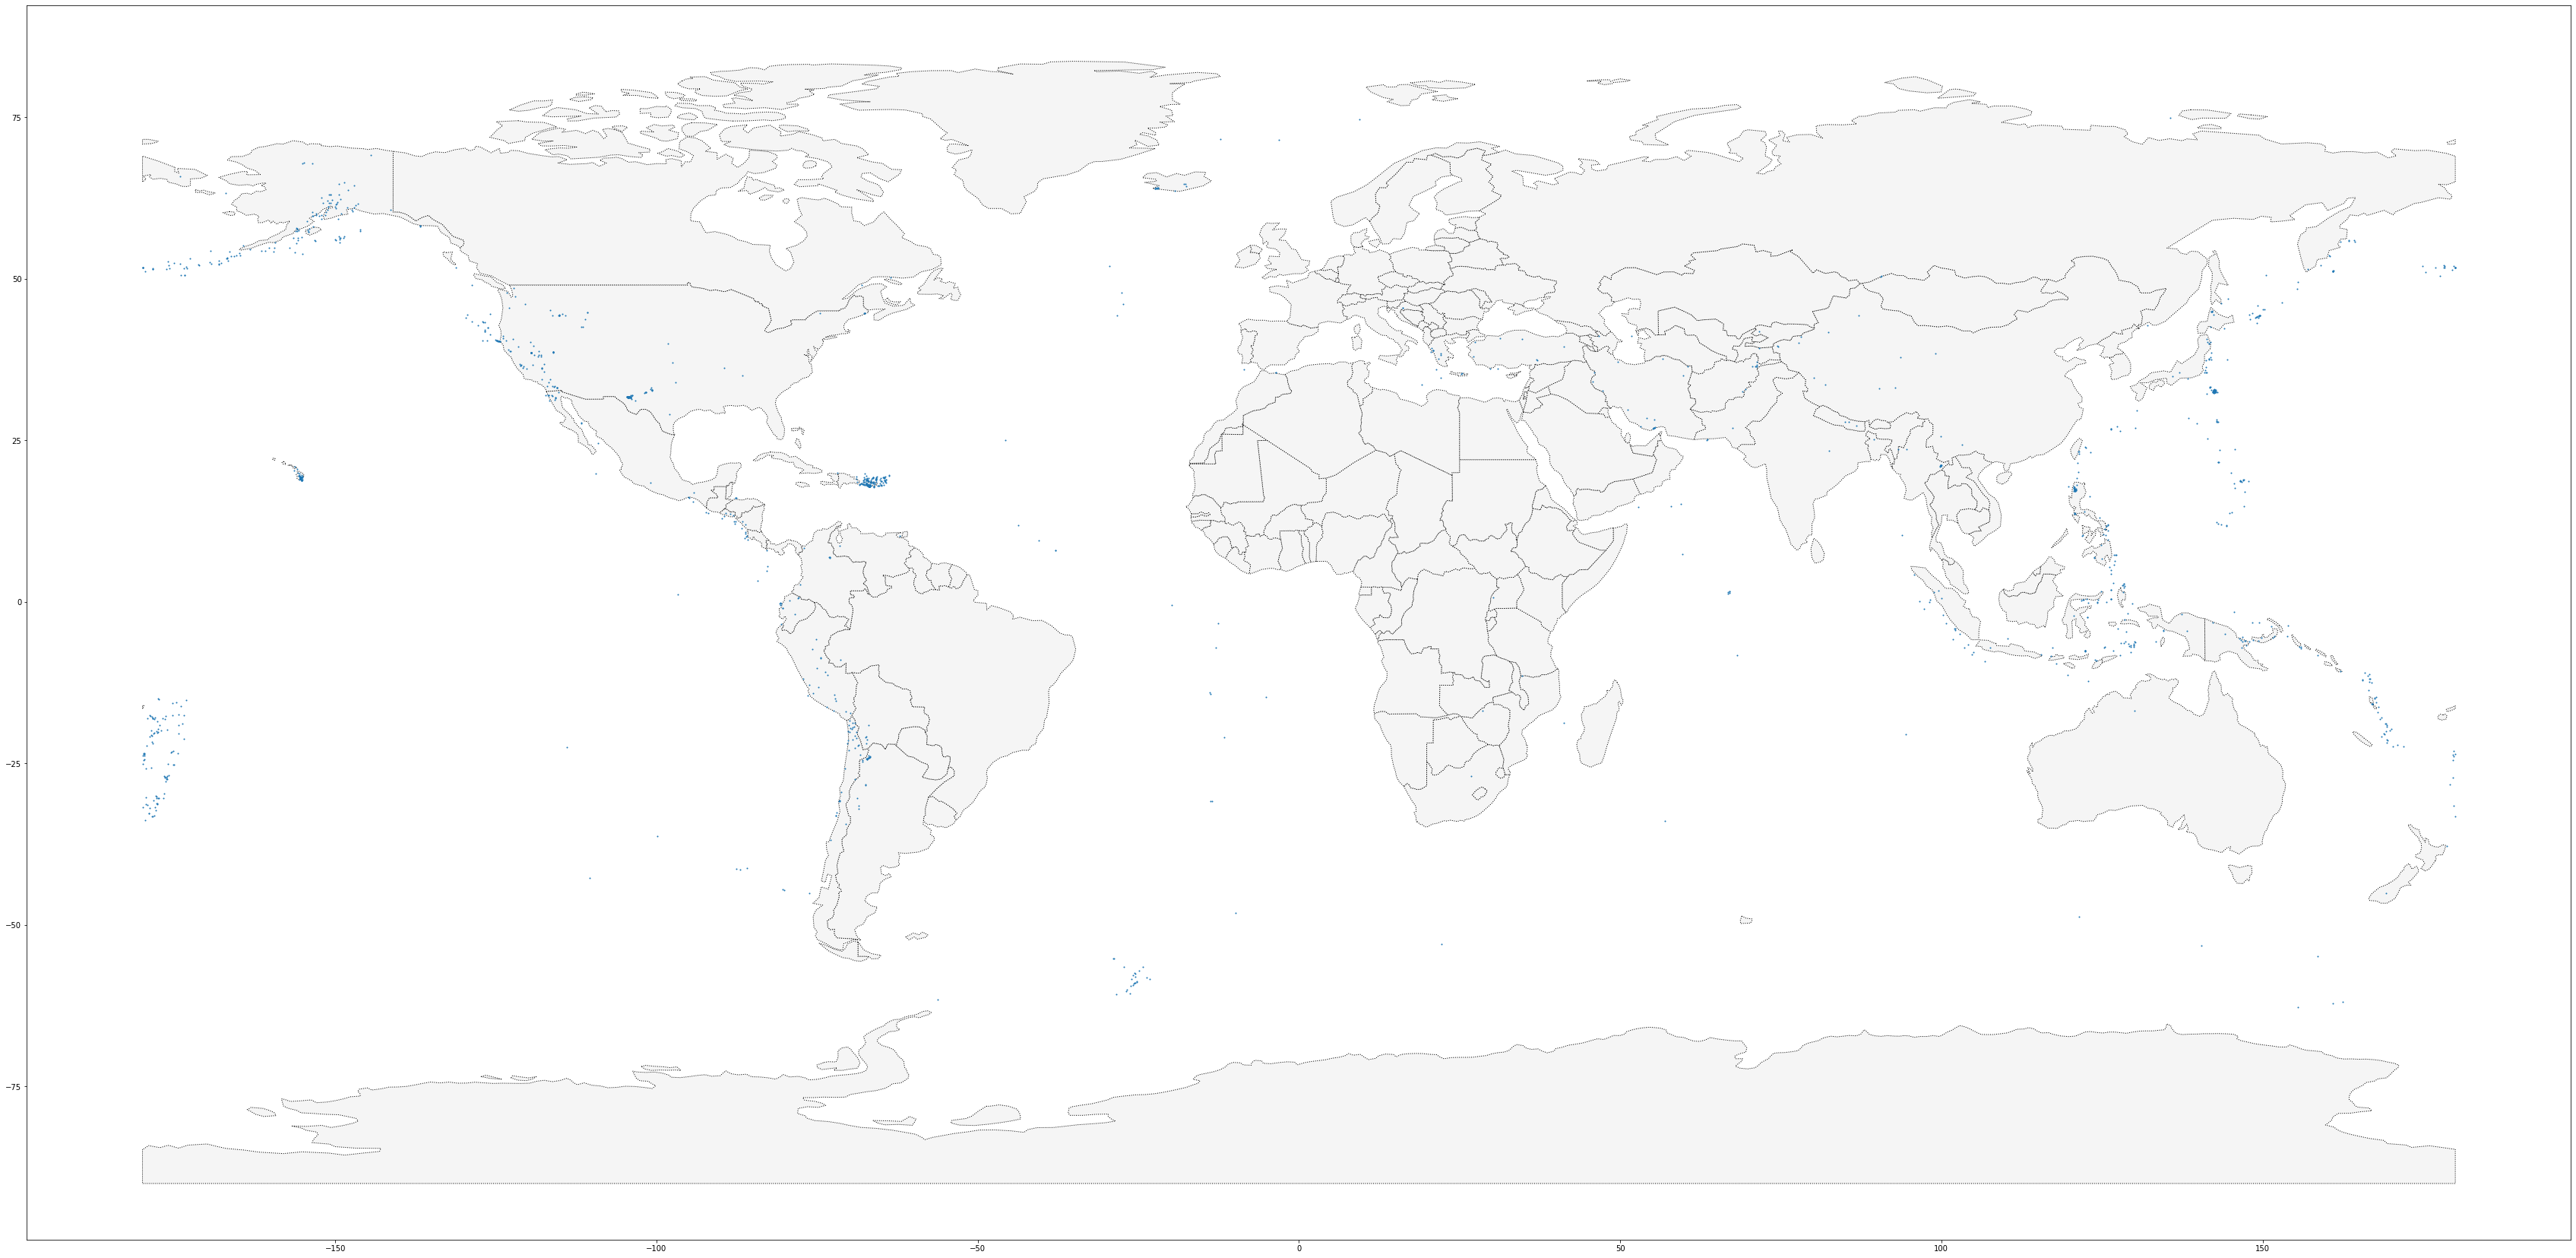

In [269]:
earthquakes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
earthquakes.crs = 'EPSG:4326'

world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)

ax = world.plot(figsize=(60, 60), color='whitesmoke', linestyle=':', edgecolor='black')
earthquakes.to_crs(epsg=4326).plot(markersize=1, ax=ax)
plt.show()

In [270]:
print(f'Min magnitude: {df["mag"].min()}')
print(f'Max magnitude: {df["mag"].max()}')

Min magnitude: 2.5
Max magnitude: 7.0


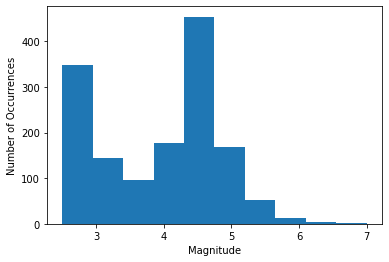

In [271]:
plt.hist(df['mag'])
plt.xlabel('Magnitude')
plt.ylabel('Number of Occurrences')
plt.show()

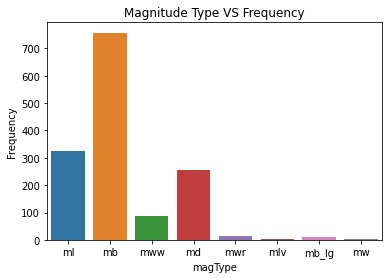

local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)


In [272]:
sns.countplot(data=df, x='magType')
plt.ylabel('Frequency')
plt.title('Magnitude Type VS Frequency')
plt.show()

print('local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)')

In [273]:
df.loc[df['mag'] >= 8, 'Class'] = 'Disastrous'
df.loc[(df['mag'] >= 7) & (df['mag'] < 7.9), 'Class'] = 'Major'
df.loc[(df['mag'] >= 6) & (df['mag'] < 6.9), 'Class'] = 'Strong'
df.loc[(df['mag'] >= 5.5) & (df['mag'] < 5.9), 'Class'] = 'Moderate'

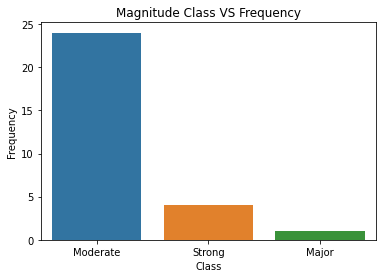

In [274]:
sns.countplot(data=df, x='Class')
plt.ylabel('Frequency')
plt.title('Magnitude Class VS Frequency')
plt.show()

## 2. Data Preparation

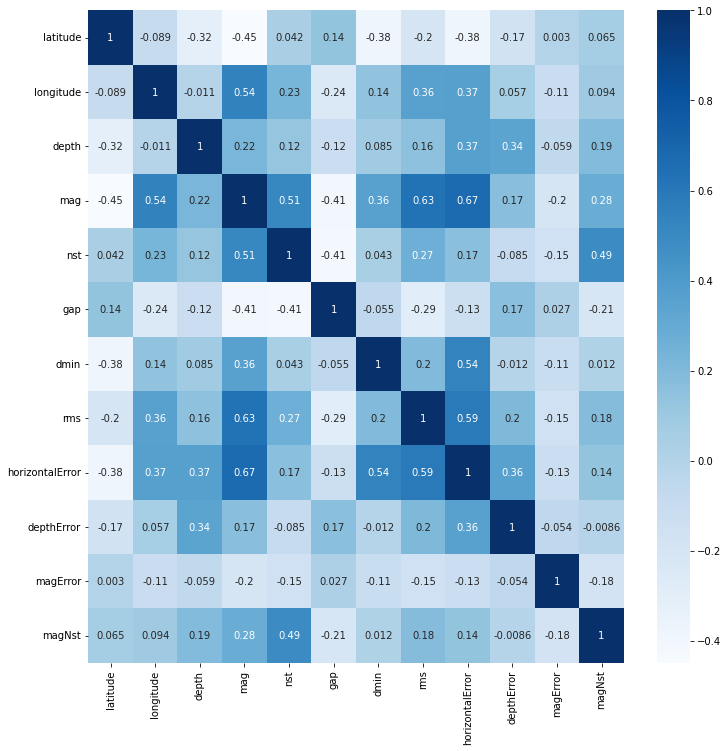

In [275]:
numeric_columns = [column for column in df.columns if df.dtypes[column] != 'object']
corr_matrix = df[numeric_columns].corr() 
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.show()

In [276]:
threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
df.drop(to_drop, axis=1, inplace=True)

In [277]:
for column in df.columns:
    if df[column].isna().mean() > 0.3:
        df.drop(column, axis=1, inplace=True) 

df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,geometry
0,2022-08-18T11:29:57.850Z,18.987499,-155.431671,33.680,2.76,ml,47.0,225.0,NaN,0.13,...,"17 km ESE of Naalehu, Hawaii",earthquake,0.55,0.930,0.630,4.0,automatic,hv,hv,POINT (-155.43167 18.98750)
1,2022-08-18T09:39:19.617Z,27.554600,139.788700,496.853,4.80,mb,122.0,45.0,5.542,0.62,...,"Bonin Islands, Japan region",earthquake,10.78,6.395,0.026,455.0,reviewed,us,us,POINT (139.78870 27.55460)
2,2022-08-18T09:28:29.331Z,23.962600,122.409900,24.596,4.40,mb,28.0,116.0,0.744,0.51,...,"81 km SW of Yonakuni, Japan",earthquake,4.92,6.785,0.155,12.0,reviewed,us,us,POINT (122.40990 23.96260)
3,2022-08-18T07:46:27.540Z,0.340300,124.375200,166.522,5.40,mww,83.0,47.0,2.111,1.00,...,"118 km SSW of Tomohon, Indonesia",earthquake,6.32,4.939,0.071,19.0,reviewed,us,us,POINT (124.37520 0.34030)
4,2022-08-18T07:21:54.330Z,18.422600,-64.788600,97.000,3.78,md,16.0,350.0,0.182,0.03,...,"10 km N of Cruz Bay, U.S. Virgin Islands",earthquake,5.57,1.010,0.110,9.0,reviewed,pr,pr,POINT (-64.78860 18.42260)


In [278]:
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,1459.000000,1459.000000,1459.000000,1459.000000,1393.000000,1393.000000,1175.000000,1459.000000,1379.000000,1459.000000,1383.000000,1387.000000
mean,17.572005,-20.248707,58.922615,3.913139,43.832735,126.474013,2.801494,0.531346,6.025692,3.784608,0.126259,42.302091
std,27.612054,119.875649,109.735295,0.893684,36.689596,68.914287,3.801281,0.298711,4.280060,4.517890,0.166470,64.821202
min,-62.742200,-179.987200,-3.630000,2.500000,3.000000,16.000000,0.000000,0.030000,0.090000,0.000000,0.000000,0.000000
25%,-1.014950,-117.478250,10.000000,3.000000,20.000000,71.000000,0.450500,0.270000,1.413743,1.333000,0.071000,11.000000
50%,18.969667,-66.879667,13.310000,4.200000,32.000000,114.000000,1.711000,0.540000,6.260000,1.907000,0.104000,20.000000
75%,36.573583,121.989150,53.522000,4.600000,55.000000,165.000000,3.693000,0.720000,9.235000,5.776500,0.154306,44.000000
max,74.923300,180.000000,647.998000,7.000000,444.000000,353.000000,37.794000,2.460000,22.570000,72.800000,3.860000,741.000000


## 3. Model Training

In [279]:
df.columns

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'geometry'],
      dtype='object')

In [280]:
features = ['latitude', 'longitude', 'nst', 'gap', 'dmin']
target = 'mag'

In [281]:
train = math.floor(len(df) * 0.8)
test = math.floor(len(df) * 0.9)

df_train = df[:train]
df_test = df[train:test]
df_validation = df[test:]

In [282]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    df[features],
    df[target], 
    test_size=0.2, 
    random_state=42,
)

In [283]:
params = {
    'max_depth': 4,
    'colsample_bytree' : 0.5,
    'n_estimators': 1000,
    'eta': 0.01,
    'early_stopping_rounds': 10,
}
model = xgb.XGBRegressor(**params)
model.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)

predictions = model.predict(x_test)
print(f'Accuracy of Model: {model.score(x_test, y_test)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, predictions)}')

Accuracy of Model: 0.8820669697095151
Mean Absolute Error: 0.22781075181533017
